In [1]:
import yfinance as yf
import pandas as pd
import numpy

In [103]:

# Download historical market data for AAPL
apple = yf.download("AAPL", start='2014-10-15', end='2024-10-24')

apple = apple.reset_index()
# Flatten the MultiIndex columns
apple.columns = [col[0] for col in apple.columns]

apple.drop(columns=['Date'], inplace=True)

[*********************100%***********************]  1 of 1 completed


In [107]:
msft = yf.download("MSFT", start='2014-10-15', end='2024-10-24')

msft = msft.reset_index()

msft.columns = [col[0] for col in msft.columns]

msft.drop(columns=['Date'], inplace=True)

[*********************100%***********************]  1 of 1 completed


In [112]:
data = pd.concat([apple, msft], ignore_index=True)

In [113]:
import pandas_ta as ta

In [114]:
data

,Adj Close,Close,High,Low,Open,Volume
0,21.651623,24.385000,24.787500,23.795000,24.492500,403734400
1,21.367489,24.065001,24.430000,23.852501,23.887501,288618000
2,21.680473,24.417500,24.750000,24.202499,24.375000,272718800
3,22.144400,24.940001,24.990000,24.555000,24.580000,310069200
4,22.745966,25.617500,25.754999,25.317499,25.754999,378495600
...,...,...,...,...,...,...
5041,416.720001,416.720001,422.500000,415.589996,422.359985,14820000
5042,418.160004,418.160004,419.649994,416.260010,417.140015,17145300
5043,418.779999,418.779999,418.959991,413.750000,416.119995,14206100
5044,427.510010,427.510010,430.579987,418.040009,418.489990,25482200


In [115]:
data['SMA15'] = ta.sma(data['Close'], length=15)
data['EMA5'] = ta.ema(data['Close'], length=5)
data['RSI15'] = ta.rsi(data['Close'], length=15)
data['BB_upper'], data['BB_lower'] = ta.bbands(data['Close'], length=56, std=2).iloc[:, [0, 2]].T.values
data['MACD'], data['MACD_signal'] = ta.macd(data['Close']).iloc[:, [0, 1]].T.values
#data['StochK'], data['StochD'] = ta.stoch(data['High'], data['Low'], data['Close']).iloc[:, [0, 1]].T.values
data['OBV'] = ta.obv(data['Close'], data['Volume'])
data['ADX'] = ta.adx(data['High'], data['Low'], data['Close']).iloc[:, 0]  # ADX Line
data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(data['High'], data['Low']).iloc[:, [0, 1]].T.values
#data['AD'] = ta.accdist(data['High'], data['Low'], data['Close'], data['Volume'])

# Show the last few rows of the dataset
data = data.iloc[14:, :]


C:\Users\Nishc\AppData\Local\Temp\ipykernel_30928\3978510302.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(data['Close']).iloc[:, [0, 1]].T.values


In [116]:
data

,Adj Close,Close,High,Low,Open,Volume,SMA15,EMA5,RSI15,BB_upper,BB_lower,MACD,MACD_signal,OBV,ADX,Aroon_Up,Aroon_Down
14,24.106682,27.150000,27.372499,26.930000,27.340000,166297600,25.981833,26.981886,NaN,NaN,NaN,NaN,NaN,2.146982e+09,NaN,0.000000,92.857143
15,24.164398,27.215000,27.325001,27.032499,27.275000,149743600,26.170500,27.059591,83.624396,NaN,NaN,NaN,NaN,2.296726e+09,NaN,0.000000,85.714286
16,24.233507,27.174999,27.197500,26.950001,27.150000,139874000,26.377833,27.098060,82.159896,NaN,NaN,NaN,NaN,2.156852e+09,NaN,0.000000,78.571429
17,24.302620,27.252501,27.330000,27.137501,27.187500,134766000,26.566833,27.149540,82.785713,NaN,NaN,NaN,NaN,2.291618e+09,NaN,0.000000,71.428571
18,24.262486,27.207500,27.332500,27.167500,27.254999,108782000,26.718000,27.168860,81.017653,NaN,NaN,NaN,NaN,2.182836e+09,NaN,0.000000,64.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5041,416.720001,416.720001,422.500000,415.589996,422.359985,14820000,418.221999,417.024648,45.924263,397.937155,437.552129,-1.782522,-0.514316,8.528343e+09,15.009403,50.000000,0.000000
5042,418.160004,418.160004,419.649994,416.260010,417.140015,17145300,417.564667,417.403100,47.715359,397.934113,437.548385,-1.649502,-0.305038,8.545488e+09,13.956973,42.857143,0.000000
5043,418.779999,418.779999,418.959991,413.750000,416.119995,14206100,416.796667,417.862066,48.502212,397.962798,437.579344,-1.477029,-0.106051,8.559694e+09,13.347073,35.714286,0.000000
5044,427.510010,427.510010,430.579987,418.040009,418.489990,25482200,417.251335,421.078047,58.030997,398.298388,437.923040,-0.628657,0.593857,8.585176e+09,13.667999,28.571429,100.000000


In [117]:
# Fill missing values using forward fill
data.fillna(method='ffill', inplace=True)

# If forward fill still leaves some NaN values at the beginning, use backward fill as a fallback
data.fillna(method='bfill', inplace=True)

# Verify the missing values are handled
print(data.isnull().sum())


Adj Close      0
Close          0
High           0
Low            0
Open           0
Volume         0
SMA15          0
EMA5           0
RSI15          0
BB_upper       0
BB_lower       0
MACD           0
MACD_signal    0
OBV            0
ADX            0
Aroon_Up       0
Aroon_Down     0
dtype: int64


C:\Users\Nishc\AppData\Local\Temp\ipykernel_30928\4028400223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='ffill', inplace=True)
C:\Users\Nishc\AppData\Local\Temp\ipykernel_30928\4028400223.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(method='bfill', inplace=True)


In [118]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Assuming your dataset is already loaded into a DataFrame called 'data'
# Define your column groups
price_columns = ['Open', 'High', 'Low', 'Adj Close', 'Close']
technical_indicators = ['SMA15', 'EMA5', 'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'ADX', 'Aroon_Up', 'Aroon_Down']
volume_column = 'Volume'

# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply Min-Max Normalization to price columns
data[price_columns] = min_max_scaler.fit_transform(data[price_columns])

# Log transformation for volume to reduce the impact of large spikes
data[volume_column] = np.log1p(data[volume_column])  # log1p is log(1 + x), which handles zero values

# Apply Min-Max Normalization to volume after log transformation
data[[volume_column]] = min_max_scaler.fit_transform(data[[volume_column]])

# Apply Standardization to technical indicators
data[technical_indicators] = standard_scaler.fit_transform(data[technical_indicators])

# Check if there are any missing values remaining (optional)
print(data.isnull().sum())


Adj Close      0
Close          0
High           0
Low            0
Open           0
Volume         0
SMA15          0
EMA5           0
RSI15          0
BB_upper       0
BB_lower       0
MACD           0
MACD_signal    0
OBV            0
ADX            0
Aroon_Up       0
Aroon_Down     0
dtype: int64


C:\Users\Nishc\AppData\Local\Temp\ipykernel_30928\1158074174.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_columns] = min_max_scaler.fit_transform(data[price_columns])
C:\Users\Nishc\AppData\Local\Temp\ipykernel_30928\1158074174.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[volume_column] = np.log1p(data[volume_column])  # log1p is log(1 + x), which handles zero values
C:\Users\Nishc\AppData\Local\Temp\ipykernel_30928\1158074174.py:22: SettingWithCopyWarning: 
A value is trying

In [119]:
data

,Adj Close,Close,High,Low,Open,Volume,SMA15,EMA5,RSI15,BB_upper,BB_lower,MACD,MACD_signal,OBV,ADX,Aroon_Up,Aroon_Down
14,0.007593,0.010259,0.010002,0.010320,0.010889,0.695455,-1.051546,-1.041687,2.332911,-1.003128,-1.047564,0.138091,-0.122966,2.146982e+09,5.364830,-1.120848,0.953378
15,0.007723,0.010405,0.009895,0.010552,0.010742,0.671999,-1.049743,-1.040947,2.332911,-1.003128,-1.047564,0.138091,-0.122966,2.296726e+09,5.364830,-1.120848,0.756739
16,0.007878,0.010315,0.009609,0.010365,0.010461,0.656747,-1.047761,-1.040580,2.214522,-1.003128,-1.047564,0.138091,-0.122966,2.156852e+09,5.364830,-1.120848,0.560100
17,0.008033,0.010489,0.009906,0.010790,0.010546,0.648424,-1.045954,-1.040090,2.265112,-1.003128,-1.047564,0.138091,-0.122966,2.291618e+09,5.364830,-1.120848,0.363462
18,0.007943,0.010388,0.009912,0.010857,0.010697,0.600509,-1.044509,-1.039906,2.122183,-1.003128,-1.047564,0.138091,-0.122966,2.182836e+09,5.364830,-1.120848,0.166823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5041,0.887895,0.885746,0.897066,0.889458,0.899573,0.154588,2.697779,2.672283,-0.714751,2.890454,2.584345,-0.581654,-0.409763,8.528343e+09,-0.973419,0.275317,-1.602927
5042,0.891124,0.888983,0.890668,0.890973,0.887829,0.187192,2.691496,2.675887,-0.569960,2.890423,2.584312,-0.548510,-0.242279,8.545488e+09,-1.066789,0.075865,-1.602927
5043,0.892514,0.890376,0.889119,0.885296,0.885534,0.145124,2.684155,2.680257,-0.506351,2.890722,2.584588,-0.505536,-0.083031,8.559694e+09,-1.120898,-0.123587,-1.602927
5044,0.912088,0.909995,0.915206,0.894999,0.890866,0.275835,2.688501,2.710880,0.263952,2.894225,2.587653,-0.294153,0.477103,8.585176e+09,-1.092426,-0.323040,1.150017


In [37]:
# data.to_csv('Apple.csv')

In [38]:
# from ydata_profiling import ProfileReport
# import pandas as pd

# # # Load your data
# # data = pd.read_csv('Apple.csv')

# # Create the profile report and specify config_file as None
# profile = ProfileReport(final_X_y, config_file=None)

# # Save the report to an HTML file
# profile.to_file("Apple_processed.html")


In [120]:
data = pd.read_csv('Apple.csv', index_col=False)

In [121]:
data.drop(columns=['Unnamed: 0'], inplace=True)

In [122]:
data

,Open,High,Low,Close,Adj Close,Volume,SMA15,EMA5,RSI15,BB_upper,BB_lower,MACD,MACD_signal,OBV,ADX,Aroon_Up,Aroon_Down
0,0.145560,0.135800,0.092953,0.121477,0.119083,0.683939,-1.340756,-1.480714,-1.170455,-1.460994,-1.402776,-0.028429,-0.402157,-1.243859e+08,-0.983383,1.629172,0.237760
1,0.100480,0.103719,0.104698,0.126387,0.123897,0.481122,-1.350067,-1.536957,-1.170455,-1.460994,-1.402776,-0.028429,-0.402157,-4.101130e+07,-0.983383,1.429739,0.043517
2,0.130352,0.124499,0.121267,0.131660,0.129067,0.510319,-1.361406,-1.566856,-1.074445,-1.460994,-1.402776,-0.028429,-0.402157,4.889720e+07,-0.983383,1.230307,-0.150726
3,0.113062,0.098250,0.094865,0.089562,0.087797,0.439734,-1.385392,-1.647425,-1.565941,-1.460994,-1.402776,-0.028429,-0.402157,-2.602060e+07,-0.983383,1.030875,-0.344970
4,0.137866,0.174079,0.139567,0.198672,0.194758,0.618326,-1.376107,-1.543980,-0.048489,-1.460994,-1.402776,-0.028429,-0.402157,9.283340e+07,-0.983383,0.831442,-0.539213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,0.929574,0.947503,0.950747,0.966358,0.966710,0.195758,1.897581,1.881408,0.289488,2.201185,1.700840,0.082029,0.277618,1.777722e+09,-1.678902,0.632010,-0.733456
487,0.974020,1.000000,0.985069,0.989544,0.989653,0.383299,1.914870,1.947711,0.531719,2.201992,1.723241,0.221277,0.589719,1.842473e+09,-1.531988,0.432577,1.208977
488,0.955825,0.951057,0.962036,0.970722,0.971029,0.134944,1.929304,1.964804,0.245244,2.207089,1.738096,0.265305,0.589160,1.808391e+09,-1.468496,0.233145,1.014733
489,0.972391,0.966825,0.968227,0.974086,0.974358,0.122384,1.941657,1.981044,0.283383,2.211370,1.753458,0.302418,0.570536,1.841385e+09,-1.379094,0.033713,0.820490


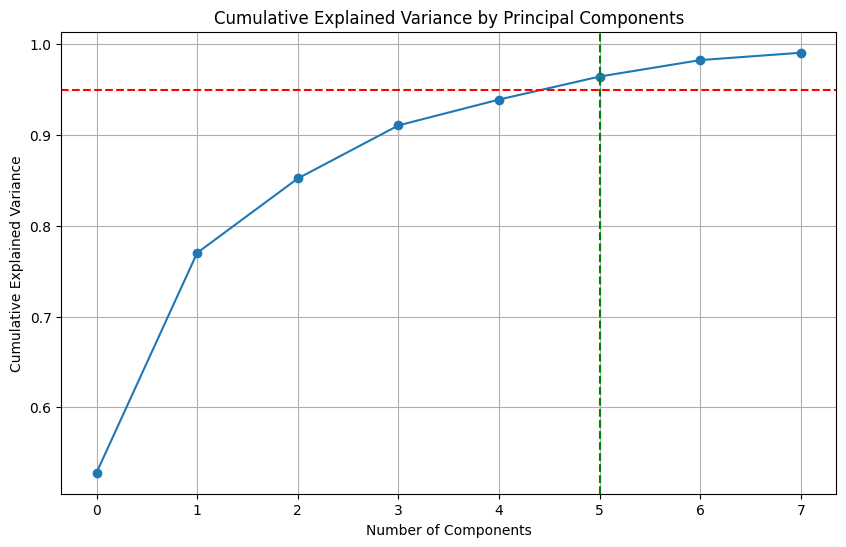

       Open      High       Low     Close  Adj Close    Volume     SMA15  \
0  0.145560  0.135800  0.092953  0.121477   0.119083  0.683939 -1.340756   
1  0.100480  0.103719  0.104698  0.126387   0.123897  0.481122 -1.350067   
2  0.130352  0.124499  0.121267  0.131660   0.129067  0.510319 -1.361406   
3  0.113062  0.098250  0.094865  0.089562   0.087797  0.439734 -1.385392   
4  0.137866  0.174079  0.139567  0.198672   0.194758  0.618326 -1.376107   

       EMA5     RSI15  BB_upper  ...  MACD_signal          OBV       ADX  \
0 -1.480714 -1.170455 -1.460994  ...    -0.402157 -124385900.0 -0.983383   
1 -1.536957 -1.170455 -1.460994  ...    -0.402157  -41011300.0 -0.983383   
2 -1.566856 -1.074445 -1.460994  ...    -0.402157   48897200.0 -0.983383   
3 -1.647425 -1.565941 -1.460994  ...    -0.402157  -26020600.0 -0.983383   
4 -1.543980 -0.048489 -1.460994  ...    -0.402157   92833400.0 -0.983383   

   Aroon_Up  Aroon_Down       PC1       PC2       PC3       PC4       PC5  
0  1.62917

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming your dataset is already loaded into a DataFrame called 'data'
# Define the columns to include in PCA (excluding any non-feature columns)
feature_columns = ['Open', 'High', 'Low', 
                   'SMA15', 'EMA5', 'RSI15', 'BB_upper', 'BB_lower', 
                   'MACD', 'MACD_signal', 'OBV', 'ADX', 'Aroon_Up', 'Aroon_Down', 'Volume']

X = data[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA(n_components=8)  # You can specify the number of components you want
X_pca = pca.fit_transform(X_scaled)

# Step 3: Explained Variance Ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--')  # Line for 95% variance threshold
plt.axvline(x=np.argmax(cumulative_variance >= 0.95), color='g', linestyle='--')  # Components needed for 95%
plt.show()

# Step 4: Transform the original data
# You can choose the number of components based on the cumulative variance plot
n_components_to_keep = np.argmax(cumulative_variance >= 0.95)  # For 95% variance
pca_final = PCA(n_components=n_components_to_keep)
X_final = pca_final.fit_transform(X_scaled)

# Create a DataFrame with the PCA results
pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
pca_df = pd.DataFrame(data=X_final, columns=pca_columns)

# Optional: Concatenate the PCA results with the original data (if needed)
result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

# Show the resulting DataFrame
print(result_df.head())


In [124]:
result_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA15', 'EMA5',
       'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'OBV', 'ADX',
       'Aroon_Up', 'Aroon_Down', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5'],
      dtype='object')

In [125]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Sample DataFrame (replace this with your actual results_df)
# results_df = pd.DataFrame(...)  # Your DataFrame with all the columns

# Step 1: Create Regression Labels
result_df['Target'] = result_df['Close'].shift(-1)  # Predicting the next day's closing price
result_df.dropna(inplace=True)  # Drop rows with NaN values resulting from the shift

# Step 2: Select Principal Components Only
# Assuming your principal components are named 'PC1', 'PC2', etc.
pc_columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
X = result_df[pc_columns]

# Step 3: Prepare your labels
y = result_df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a Random Forest Regressor using only the PCs
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

mse = 8.820687104646261
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')



Mean Squared Error: 0.000708344876532373
Root Mean Squared Error (RMSE): 2.9699641588150962


Mean Squared Error: 9.055984229744459
Root Mean Squared Error (RMSE): 2.9699641588150962

In [126]:
import pandas as pd

# Assuming you already have y_test (actual prices) and y_pred (predicted prices)

# Create a DataFrame to compare actual vs predicted prices
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Print the first few rows of the results
print(results.head())

# Optionally, print the entire DataFrame
# If the dataset is large, you may want to just print specific rows or summary statistics
# print(results)


       Actual  Predicted
452  0.936625   0.934139
84   0.213493   0.225125
434  0.848700   0.886605
473  0.931988   0.929585
428  0.850336   0.912726


In [128]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

# Step 1: Create Regression Labels
result_df['Target'] = result_df['Close'].shift(-1)  # Predicting the next day's closing price
result_df.dropna(inplace=True)  # Drop rows with NaN values resulting from the shift

# Step 2: Select Principal Components Only
pc_columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
X = result_df[pc_columns]
y = result_df['Target']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Build the Neural Network Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),  # Input layer
    layers.Dense(32, activation='relu'),  # Hidden layer
    layers.Dense(1)  # Output layer for regression
])

# Step 6: Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 7: Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Step 8: Predict on the test set
y_pred = model.predict(X_test_scaled)

# Step 9: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Step 10: Create a DataFrame to compare actual vs predicted prices
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred.flatten()  # Flatten to convert from 2D to 1D
})

# Print the first few rows of the results
print(results.head())


Epoch 1/100


c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


10/10 [==============================] - 0s 14ms/step - loss: 0.5093 - val_loss: 0.2234
Epoch 2/100
10/10 [==============================] - 0s 7ms/step - loss: 0.1504 - val_loss: 0.1054
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0747 - val_loss: 0.0686
Epoch 4/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0375 - val_loss: 0.0342
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.0253
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.0225
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0152 - val_loss: 0.0221
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0179
Epoch 9/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0158
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0145
Epoch 11/100
10/10 [

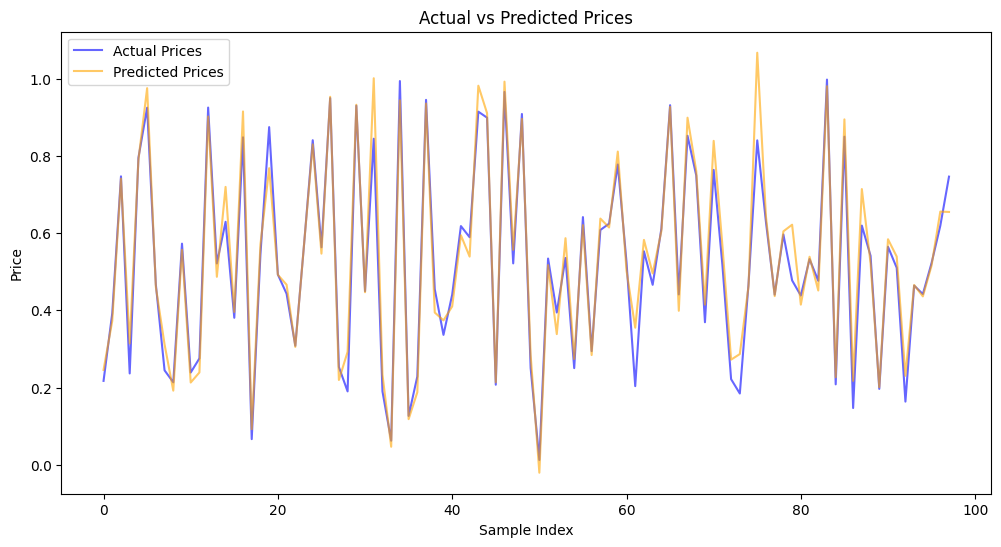

In [129]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue', alpha=0.6)
plt.plot(y_pred, label='Predicted Prices', color='orange', alpha=0.6)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.show()


Linear Regression:
  Mean Squared Error (MSE): 0.0009300727865422891
  Mean Absolute Error (MAE): 0.02338741496498823
  Root Mean Squared Error (RMSE): 0.030497094722977944
  R-squared: 0.9856281518900767



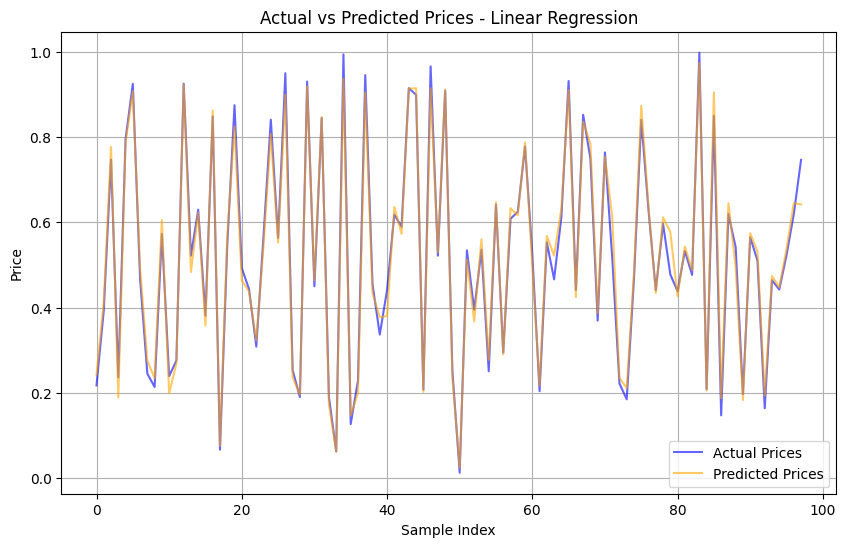

Decision Tree:
  Mean Squared Error (MSE): 0.0019430668428222042
  Mean Absolute Error (MAE): 0.0309945003427205
  Root Mean Squared Error (RMSE): 0.04408023188258206
  R-squared: 0.9699749719199002



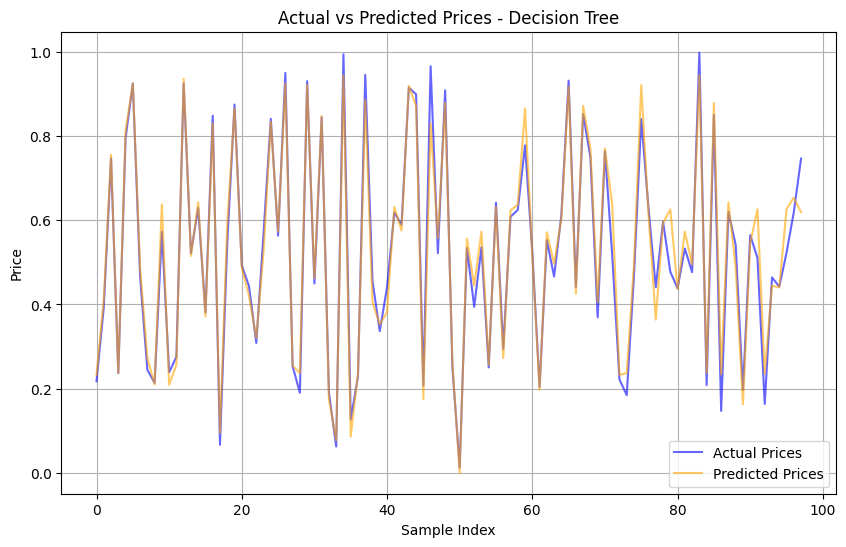

Random Forest:
  Mean Squared Error (MSE): 0.0012362613058195778
  Mean Absolute Error (MAE): 0.02606517057654778
  Root Mean Squared Error (RMSE): 0.03516050775827303
  R-squared: 0.9808968072515403



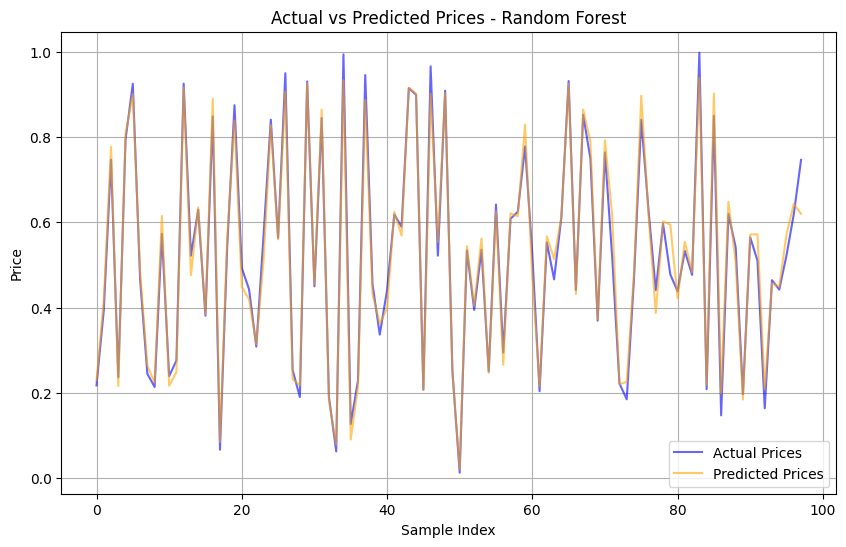

Gradient Boosting:
  Mean Squared Error (MSE): 0.0012598304622179134
  Mean Absolute Error (MAE): 0.026317668357990858
  Root Mean Squared Error (RMSE): 0.03549409052529609
  R-squared: 0.9805326074375718



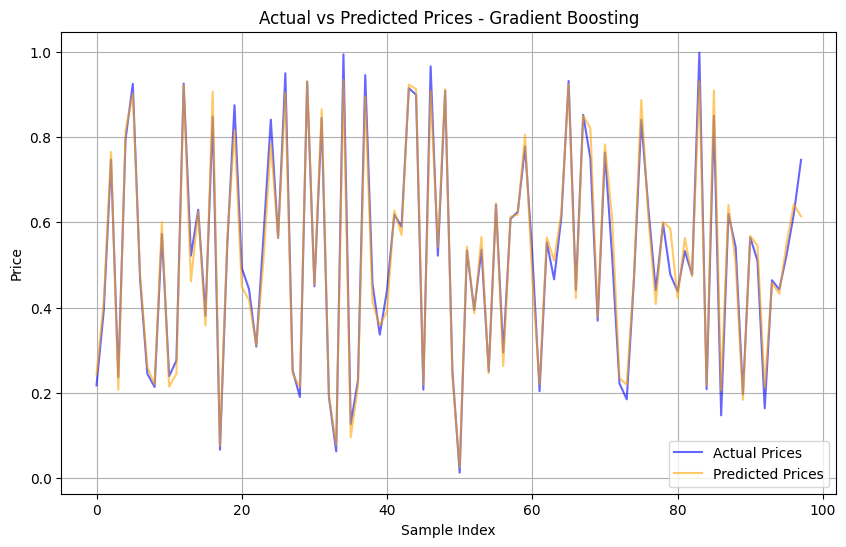

Support Vector Regression:
  Mean Squared Error (MSE): 0.0036789428941778482
  Mean Absolute Error (MAE): 0.05221383400141107
  Root Mean Squared Error (RMSE): 0.06065428998989147
  R-squared: 0.9431515369062984



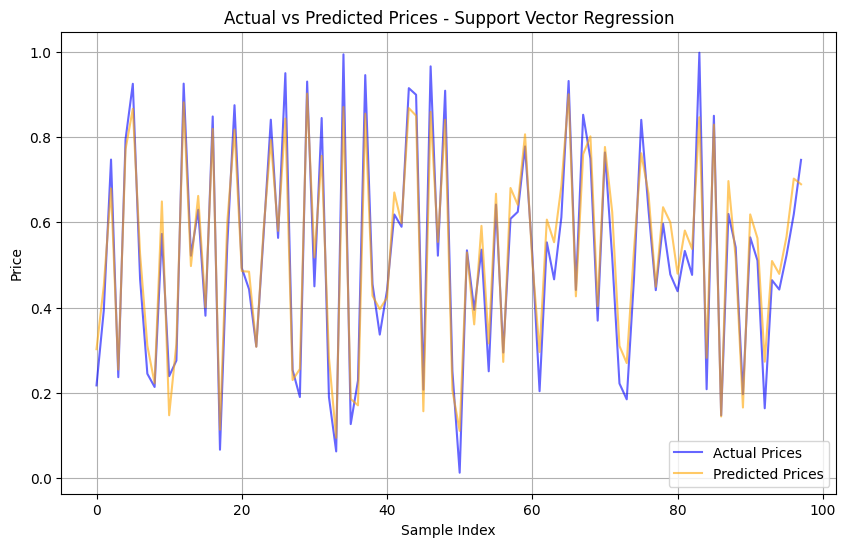

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Create a dictionary of models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regression': SVR()
}

# Dictionary to store results
results = {}

# Loop through each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r_squared = r2_score(y_test, y_pred)

    # Store results
    results[model_name] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R-squared': r_squared,
        'Predictions': y_pred
    }

    # Print metrics
    print(f'{model_name}:')
    print(f'  Mean Squared Error (MSE): {mse}')
    print(f'  Mean Absolute Error (MAE): {mae}')
    print(f'  Root Mean Squared Error (RMSE): {rmse}')
    print(f'  R-squared: {r_squared}')
    print()

    # Plotting Actual vs Predicted Prices
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Prices', color='blue', alpha=0.6)
    plt.plot(y_pred, label='Predicted Prices', color='orange', alpha=0.6)
    plt.title(f'Actual vs Predicted Prices - {model_name}')
    plt.xlabel('Sample Index')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Optionally, if you want to inspect predictions for a specific model:
# print(pd.DataFrame({'Actual': y_test, 'Predicted': results['Random Forest']['Predictions']}))


In [ ]:
X, y

In [22]:
final_X_y = combined_df = pd.concat([X, y], axis=1)  # Use axis=1 to concatenate columns


In [24]:
final_X_y.to_csv('Apple_PreProcessed.csv', index=False)

In [83]:
close = result_df['Close']
print(X.shape)
close.shape

(488, 6)


(488,)

In [86]:
X.drop(columns='Close')

,PC1,PC2,PC3,PC4,PC5,PC6
0,-5.162991,-0.541986,0.220062,2.357983,1.090055,0.380979
1,-5.011012,-0.549788,0.041705,0.720092,1.141468,0.306821
2,-4.892773,-0.498447,0.095553,0.914384,1.002279,0.026247
3,-5.109180,-0.715333,0.030174,0.286908,0.758728,-0.010733
4,-4.668417,-0.011019,0.266225,1.697555,0.806845,-0.693817
...,...,...,...,...,...,...
483,5.152529,-2.638474,-1.411924,-0.713939,0.876088,-0.977746
484,5.274330,-2.607776,-1.534213,-1.258563,0.711122,-1.124922
485,5.281182,-2.233062,-1.712728,-0.845524,0.816643,-0.523317
486,5.387174,-1.909324,-1.667759,-0.162987,0.603943,-0.871710


In [87]:
X_new = pd.concat([X,close], axis=1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'data' is your original DataFrame containing the feature columns

# Step 1: Fit PCA
pca = PCA(n_components=6)
pca.fit(data)

# Step 2: Transform the data
X = pca.transform(data)

# Step 3: Retrieve component loadings
loadings = pd.DataFrame(pca.components_.T, index=data.columns, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
print("Component Loadings:")
print(loadings)

# Step 4: Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Each Component:", explained_variance)

# Step 5: Visualize the first two principal components with a biplot
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)

# Add arrows for feature contributions
for i, feature in enumerate(data.columns):
    plt.arrow(0, 0, loadings.iloc[i, 0], loadings.iloc[i, 1], 
              color='r', alpha=0.5, head_width=0.05)
    plt.text(loadings.iloc[i, 0], loadings.iloc[i, 1], feature, 
             color='black', ha='center', va='center')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot of PCA')
plt.grid()
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
plt.show()


In [88]:
import pandas as pd
import numpy as np

def create_labels(data, label_type, threshold=None):
    """
    Create labels for different classification types.
    
    Args:
    - data: DataFrame containing the features.
    - label_type: Type of classification ('binary', 'multiclass', 'conditional').
    - threshold: Threshold for binary classification (for 'binary' and 'multi-class').
    
    Returns:
    - labels: Series of labels.
    """
    # Example target column: 'Close'
    target_column = 'Close'
    
    # Ensure the target column exists in the DataFrame
    if target_column not in data.columns:
        raise ValueError(f"{target_column} not found in DataFrame.")
    
    if label_type == 'binary':
        if threshold is None:
            threshold = data[target_column].median()  # Default threshold to median
        labels = (data[target_column] > threshold).astype(int)  # 1 if above threshold, else 0
    
    elif label_type == 'multiclass':
        bins = [0, 100, 150, 200, np.inf]  # Define your bins
        labels = pd.cut(data[target_column], bins=bins, labels=[0, 1, 2, 3], right=False)
    
    elif label_type == 'conditional':
        labels = np.where(data[target_column] > data[target_column].mean(), 1, 0)  # 1 if above average, else 0
    
    else:
        raise ValueError("Invalid label_type. Choose 'binary', 'multiclass', or 'conditional'.")
    
    return labels


In [90]:
labels = create_labels(X, "binary")

0      0
1      0
2      0
3      0
4      0
      ..
483    1
484    1
485    1
486    1
487    1
Name: Close, Length: 488, dtype: int32

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def classify_and_evaluate(data, label_type, threshold=None):
    """
    Classify and evaluate the model performance on various algorithms.
    
    Args:
    - data: DataFrame containing the features and target.
    - label_type: Type of classification ('binary', 'multiclass', 'conditional').
    - threshold: Threshold for binary classification.
    
    Returns:
    - None (prints model evaluations).
    """
    # Create labels
    labels = create_labels(data, label_type, threshold)
    
    # Define features (excluding target)
    feature_columns = [col for col in data.columns if col != 'Close']  # Adjust as needed
    X = data[feature_columns]
    y = labels
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    y_train = y_train.iloc[:,0]
    y_test = y_test.iloc[:,0]
    # Initialize classifiers
    classifiers = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=200),
        'Support Vector Classifier': SVC(),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }
    
    # Evaluate each classifier
    for name, clf in classifiers.items():
        print(X_train.head())
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(report)

classify_and_evaluate(X_new, label_type='binary', threshold=150)  # Adjust threshold as needed


          PC1       PC2       PC3       PC4       PC5       PC6
415  4.525141  1.789435  1.421528 -0.646582  0.796932  0.808185
314  0.814330 -1.617865 -0.539504  0.014556  0.266293 -0.090640
25  -4.701296 -1.100486 -0.380481  0.119212  1.045310 -0.977684
222 -1.030559 -2.669881  0.105975  0.308785 -0.169799  0.080492
298  0.017101 -2.350513  0.340390  0.258032 -0.705902 -0.465540
Random Forest Accuracy: 0.9082
              precision    recall  f1-score   support

           0       0.90      0.53      0.67        17
           1       0.91      0.99      0.95        81

    accuracy                           0.91        98
   macro avg       0.90      0.76      0.81        98
weighted avg       0.91      0.91      0.90        98

          PC1       PC2       PC3       PC4       PC5       PC6
415  4.525141  1.789435  1.421528 -0.646582  0.796932  0.808185
314  0.814330 -1.617865 -0.539504  0.014556  0.266293 -0.090640
25  -4.701296 -1.100486 -0.380481  0.119212  1.045310 -0.977684
22

In [93]:
y.shape


(488,)